#Part 1: Importing the Data

In [42]:
!pip install -q numpy==1.26.4 pandas==2.2.2 tensorflow==2.17.1

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

# random seeds for replication
tf.keras.utils.set_random_seed(33)

In [3]:
data = pd.read_csv('questions.csv')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
data.shape

(404351, 6)

In [5]:
N_train = 300000
N_test = 10000

data_train = data[:N_train]
data_test = data[N_train : N_train + N_test]
print("Train set:", len(data_train), "Test set:", len(data_test))


Train set: 300000 Test set: 10000


In [6]:
all_train_dup = data_train[data_train['is_duplicate'] == 1]

Q1_train = np.array(all_train_dup['question1'])
Q2_train = np.array(all_train_dup['question2'])

Q1_test = np.array(data_test['question1'])
Q2_test = np.array(data_test['question2'])

In [7]:
print('TRAINING QUESTIONS:\n')
print('Question 1: ', Q1_train[0])
print('Question 2: ', Q2_train[0], '\n')
print('Question 1: ', Q1_train[5])
print('Question 2: ', Q2_train[5], '\n')

print('TESTING QUESTIONS:\n')
print('Question 1: ', Q1_test[0])
print('Question 2: ', Q2_test[0], '\n')

TRAINING QUESTIONS:

Question 1:  Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Question 2:  I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me? 

Question 1:  What would a Trump presidency mean for current international master’s students on an F1 visa?
Question 2:  How will a Trump presidency affect the students presently in US or planning to study in US? 

TESTING QUESTIONS:

Question 1:  How do I prepare for interviews for cse?
Question 2:  What is the best way to prepare for cse? 



In [8]:
# divide training into training and validation
cut_off = int(len(Q1_train) * 0.8)

train_Q1 = Q1_train[:cut_off]
train_Q2 = Q2_train[:cut_off]

val_Q1 = Q1_train[cut_off:]
val_Q2 = Q2_train[cut_off:]

In [9]:
print('Number of duplicate questions: ', len(Q1_train))
print("The length of the training set is:  ", len(train_Q1))
print("The length of the validation set is: ", len(val_Q1))

Number of duplicate questions:  111486
The length of the training set is:   89188
The length of the validation set is:  22298


In [10]:
# build vocab using TextVectorization
text_vectorization = tf.keras.layers.TextVectorization(standardize = 'strip_punctuation')
text_vectorization.adapt(np.concatenate((train_Q1,train_Q2)))

In [11]:
text_vectorization.vocabulary_size()

32819

In [12]:
print('first question in the train set:\n')
print(Q1_train[0], '\n')
print('encoded version:')
print(text_vectorization(Q1_train[0]),'\n')

print('first question in the test set:\n')
print(Q1_test[0], '\n')
print('encoded version:')
print(text_vectorization(Q1_test[0]) )

first question in the train set:

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me? 

encoded version:
tf.Tensor(
[ 6123     6   178    10  9079  2220 32055   788    13  6047 25433    30
    28   463    45    98], shape=(16,), dtype=int64) 

first question in the test set:

How do I prepare for interviews for cse? 

encoded version:
tf.Tensor([    4     8     6   157    17  1909    17 11616], shape=(8,), dtype=int64)


#Part 2: Defining the Siamese model

In [13]:
def Siamese(text_vectorization, vocab_size, embed_dim):

    model = tf.keras.models.Sequential([

        text_vectorization,
        tf.keras.layers.Embedding(vocab_size, embed_dim),
        tf.keras.layers.LSTM(embed_dim ,return_sequences=True),
        # reduce dimensions from (batch_size, seq_len, hidden_dim) to (batch_size, hidden_dim)
        tf.keras.layers.GlobalAveragePooling1D(),
        # The Lambda layer in Keras is a way to wrap arbitrary TensorFlow
        # operations (like tf.math.l2_normalize) into a layer that Keras can understand
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x,axis = -1)),
    ])

    input1 = tf.keras.layers.Input((1,), dtype = tf.string, name='input_1')
    input2 = tf.keras.layers.Input((1,), dtype = tf.string, name='input_2')

    model1 = model(input1)
    model2 = model(input2)

    output = tf.keras.layers.concatenate([model1, model2],axis = -1)

    return tf.keras.models.Model(inputs = (input1, input2), outputs = output)

In [14]:
vocab_size = text_vectorization.vocabulary_size()
embed_dim = 128
model = Siamese(text_vectorization, vocab_size, embed_dim)

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_2 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128)            │      4,332,416 │ input_1[0][0],         │
│                           │                        │                │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256)            │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential[1][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,332,416 (16.53 MB)

 Trainable params: 4,332,416 (16.53 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# model waits 2 inputs
input_1 = tf.constant([train_Q1[0]])
input_2 = tf.constant([train_Q2[0]])

predictions = model((input_1, input_2))

In [17]:
# the model output shape is [1, 256] because the hidden dim is 128, and we concatenate 2 models together
predictions.shape

TensorShape([1, 256])

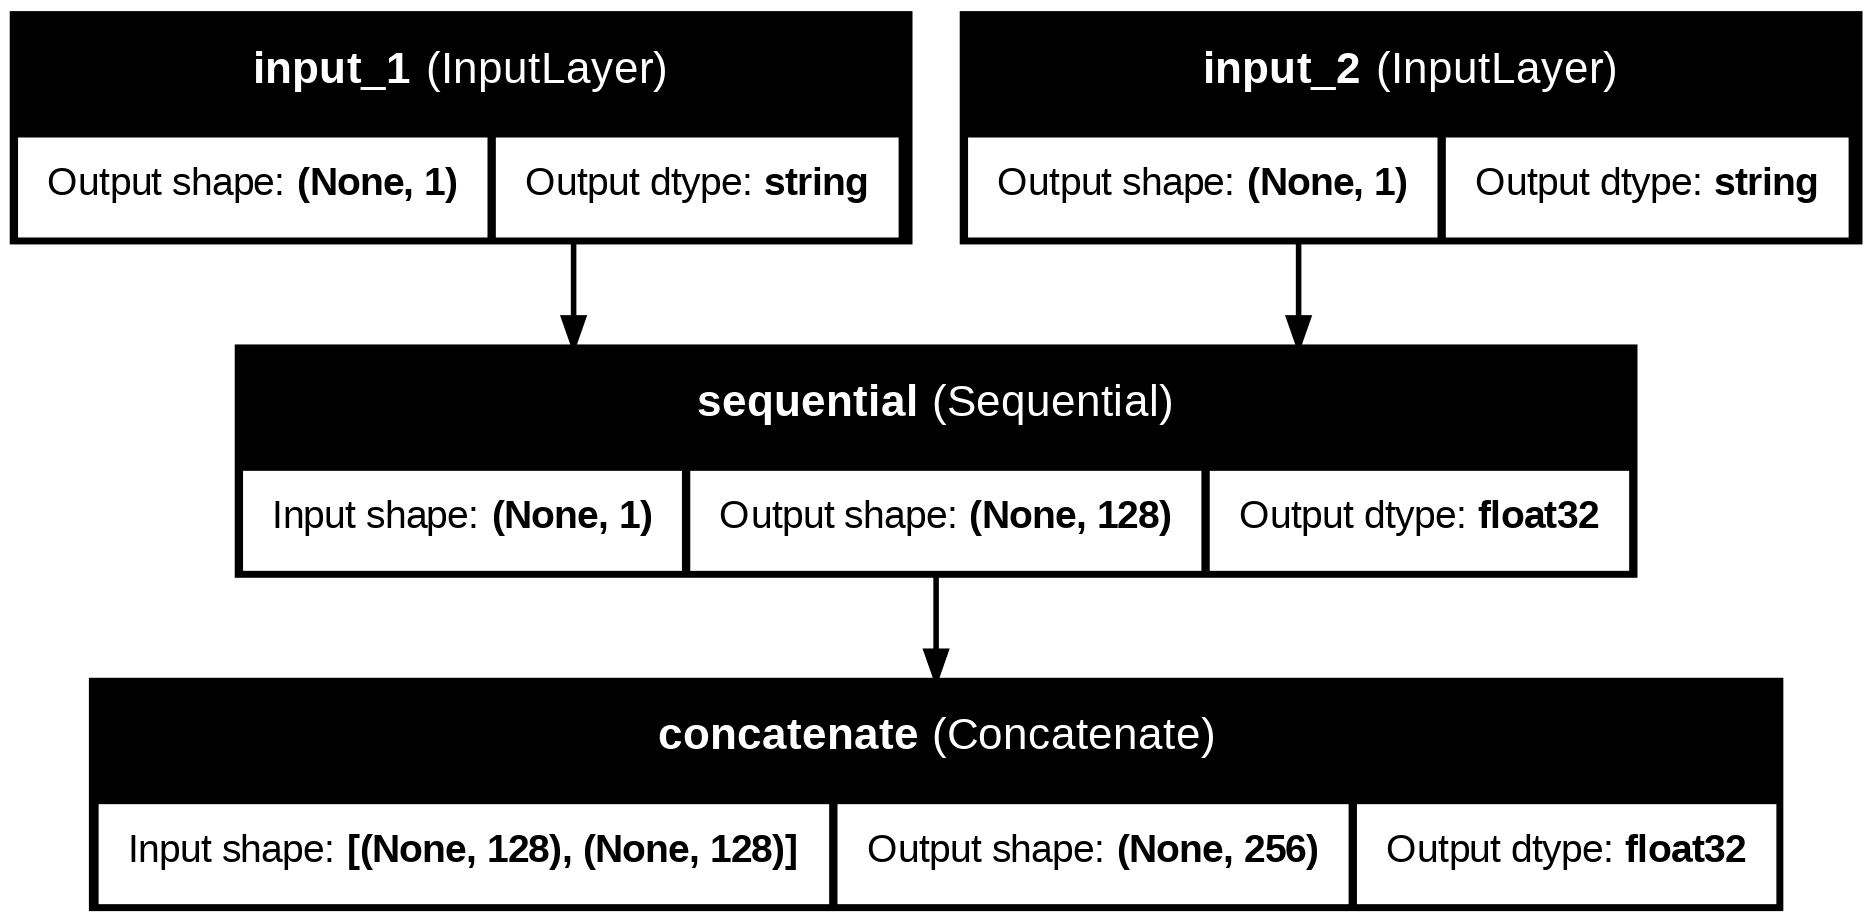

In [18]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True)

#triplet loss

In [19]:
def TripletLossFn(v1, v2,  margin = 0.25):

    "Custom Loss function"

    # use `tf.linalg.matmul` to take the dot product of the two batches.
    # Don't forget to transpose the second argument using `transpose_b=True`
    scores = tf.linalg.matmul(
        tf.linalg.l2_normalize(v2, axis=1),
        tf.linalg.l2_normalize(v1, axis=1),
        transpose_b=True
    )
    # calculate new batch size and cast it as the same datatype as scores.

    batch_size = tf.cast(tf.shape(v1)[0], scores.dtype)
    # get the cosine similarity of all positive examples (diagonal)
    positive = tf.linalg.diag_part(scores)
    # subtract the diagonal from scores. You can do this by creating a diagonal matrix with the values
    # of all positive examples using `tf.linalg.diag`
    negative_zero_on_duplicate = scores - tf.linalg.diag(positive)
    # use `tf.math.reduce_sum` on `negative_zero_on_duplicate` for `axis=1` and divide it by `(batch_size - 1)`
    mean_negative = tf.math.reduce_sum(negative_zero_on_duplicate, axis=1) / (batch_size-1)
    # create a composition of two masks:
    # the first mask to extract the diagonal elements (make sure you use the variable batch_size here),
    # the second mask to extract elements in the negative_zero_on_duplicate matrix that are larger than the elements in the diagonal
    mask_exclude_positives = (tf.eye(batch_size)==1)|(negative_zero_on_duplicate > tf.expand_dims(positive,1))
    mask_exclude_positives = tf.cast(mask_exclude_positives, scores.dtype)

    # multiply `mask_exclude_positives` with 2.0 and subtract it out of `negative_zero_on_duplicate`
    negative_without_positive = negative_zero_on_duplicate - 2.0 * mask_exclude_positives
    # take the row by row `max` of `negative_without_positive`.
    # Hint: `tf.math.reduce_max(negative_without_positive, axis = None)`
    closest_negative = tf.math.reduce_max(negative_without_positive, axis=1)
    # compute `tf.maximum` among 0.0 and `A`
    # A = subtract `positive` from `margin` and add `closest_negative`
    triplet_loss1 = tf.maximum(0.0, closest_negative - positive + margin)
    # compute `tf.maximum` among 0.0 and `B`
    # B = subtract `positive` from `margin` and add `mean_negative`
    triplet_loss2 = tf.maximum(0.0, mean_negative - positive + margin)
    # add the two losses together and take the `tf.math.reduce_sum` of it
    triplet_loss = tf.math.reduce_sum(triplet_loss1+triplet_loss2)

    return triplet_loss

In [20]:
v1 = np.array([[0.26726124, 0.53452248, 0.80178373],[0.5178918 , 0.57543534, 0.63297887]])
v2 = np.array([[ 0.26726124,  0.53452248,  0.80178373],[-0.5178918 , -0.57543534, -0.63297887]])
print("Triplet Loss:", TripletLossFn(v1,v2).numpy())

Triplet Loss: 0.703507689728441


In [21]:
def TripletLoss(labels, out, margin=0.25):

    _, out_size = out.shape # get embedding size

    v1 = out[:,:int(out_size/2)] # Extract v1 from out
    v2 = out[:,int(out_size/2):] # Extract v2 from out

    return TripletLossFn(v1, v2, margin = margin)

#training the model

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ((train_Q1, train_Q2), # training data
     tf.constant([1]*len(train_Q1))) # training labels
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    ((val_Q1, val_Q2), # val data
     tf.constant([1]*len(val_Q1))) # val labels
)

In [23]:
def train_model(Siamese, TripletLoss, text_vectorizer, train_dataset,
                val_dataset, train_steps=4, d_feature=128, lr=0.01):

    "Training the Siamese Model"

    # Instantiate your Siamese model
    model = Siamese(text_vectorizer,
                    vocab_size = text_vectorizer.vocabulary_size(),
                    embed_dim = d_feature)

    # Compile the model
    model.compile(loss=TripletLoss,
                  optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
            )

    # Train the model
    model.fit(train_dataset,
              epochs = train_steps,
              validation_data = val_dataset,
             )

    return model

In [32]:
train_steps = 10
batch_size = 64

train_generator = train_dataset.shuffle(len(train_Q1),
                                        seed=7,
                                        reshuffle_each_iteration=True).batch(batch_size=batch_size)

val_generator = val_dataset.shuffle(len(val_Q1),
                                   seed=7,
                                   reshuffle_each_iteration=True).batch(batch_size=batch_size)

model = train_model(
    Siamese = Siamese,
    TripletLoss = TripletLoss,
    text_vectorizer = text_vectorization,
    train_dataset = train_generator,
    val_dataset = val_generator,
    train_steps = train_steps,
)

Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 9.3946 - val_loss: 2.2471
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 1.6041 - val_loss: 1.7286
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 1.1703 - val_loss: 1.6464
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 1.0655 - val_loss: 1.7011
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 1.0721 - val_loss: 1.6991
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 1.0991 - val_loss: 1.7376
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 1.0962 - val_loss: 1.8259
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 1.1273 - val_loss: 1.8294
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 1.1642 - val_loss: 1.9622
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 1.2029 - val_loss: 1.9829


In [31]:
# save_path = 'weights.keras'
# model.save(save_path)

In [26]:
model.load_weights(save_path)

#eval the model

In [27]:
def evaluation(test_Q1, test_Q2, y_test, threshold, model, batch_size=64, verbose=True):

    "Function to test the accuracy of the model."

    y_pred = []
    test_gen = tf.data.Dataset.from_tensor_slices(((test_Q1, test_Q2),None)).batch(batch_size=batch_size)

    pred = model.predict(test_gen)
    _, n_feat = pred.shape
    v1 = pred[:,:int(n_feat/2)]
    v2 = pred[:, int(n_feat/2):]

    # Compute the cosine similarity. Using `tf.math.reduce_sum`.
    # Don't forget to use the appropriate axis argument.
    d  = tf.math.reduce_sum(v1*v2, axis=1)/tf.math.sqrt(tf.math.reduce_sum(v1*v1, axis=1)*tf.math.reduce_sum(v2*v2, axis=1))
    # Check if d>threshold to make predictions
    y_pred = tf.cast(d>threshold, tf.float64)
    # take the average of correct predictions to get the accuracy
    accuracy = tf.math.reduce_mean(tf.cast(y_pred==y_test, tf.float64))
    # compute the confusion matrix using `tf.math.confusion_matrix`
    cm = tf.math.confusion_matrix(y_test, y_pred)

    return accuracy, cm

In [35]:
y_test  = np.array(data_test['is_duplicate'])

accuracy, cm = evaluation(Q1_test,Q2_test, y_test, 0.7, model,  batch_size = 64)

print("Accuracy", accuracy.numpy())
print(f"Confusion matrix:\n{cm.numpy()}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy 0.7088
Confusion matrix:
[[4773 1463]
 [1449 2315]]


In [29]:
def predict(question1, question2, threshold, model, verbose=False):

    "Function for predicting if two questions are duplicates."

    generator = tf.data.Dataset.from_tensor_slices((([question1], [question2]),None)).batch(batch_size=1)

    # Call the predict method of your model and save the output into v1v2
    v1v2 = model.predict(generator)

    # Extract v1 and v2 from the model output
    _, n = v1v2.shape
    v1 = v1v2[:,:int(n/2)]
    v2 = v1v2[:, int(n/2):]

    # Take the dot product to compute cos similarity of each pair of entries, v1, v2
    # Since v1 and v2 are both vectors, use the function tf.math.reduce_sum instead of tf.linalg.matmul
    d = tf.math.reduce_sum(v1 * v2, axis=1)/tf.math.sqrt(tf.math.reduce_sum(v1*v1, axis=1)*tf.math.reduce_sum(v2 * v2, axis=1))

    # Is d greater than the threshold?
    res = d > threshold

    if verbose:
        print("Q1  = ", question1, "\nQ2  = ", question2)
        print("d   = ", d.numpy())
        print("res = ", res.numpy())

    return res.numpy()

In [37]:
question1 = "When will I see you?"
question2 = "When can I see you again?"

# 1 means it is duplicated, 0 otherwise
predict(question1 , question2, 0.7, model, verbose = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Q1  =  When will I see you? 
Q2  =  When can I see you again?
d   =  [0.8144167]
res =  [ True]


array([ True])